In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, utils
from einops import rearrange
import os
from torchvision.transforms import (
    RandomHorizontalFlip,
    RandomRotation,
    RandomVerticalFlip,
    RandomApply,
    InterpolationMode,
    RandomCrop,
    RandomResizedCrop,
    CenterCrop
)
import math
import csv
import random
from torchvision.transforms.functional import hflip
from torchvision.transforms.functional import vflip
import og_mae
from youssef_ganglia_data_loading import HirschImagesDataset
from metrics import mean_iou
from sklearn.metrics import confusion_matrix
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def augment_image_with_map(_img, _mapp, _mapc):
    side_outer = 512
    angle = torch.randint(low=0, high=90, size=(1,)).item()
    
    aug1 = torch.nn.Sequential(RandomRotation((angle, angle)))
    
    side_inner = side_outer / (math.cos(math.radians(angle)) + math.sin(math.radians(angle)))
    #print(f"The new h and w are: {side_inner}")
    
    state = torch.get_rng_state()
    _img = aug1(_img)

    torch.set_rng_state(state)
    _mapp = aug1(_mapp)
    
    torch.set_rng_state(state)
    _mapc = aug1(_mapc)
    
    center_x = side_outer // 2
    center_y = side_outer // 2

    half_width = side_inner // 2
    half_height = side_inner // 2 

    start_x = round(center_x - half_width)
    end_x = round(center_x + half_width)
    start_y = round(center_y - half_height)
    end_y = round(center_y + half_height)

    _img = _img[:, start_y:end_y, start_x:end_x]
    _mapp = _mapp[:, start_y:end_y, start_x:end_x]
    _mapc = _mapc[:, start_y:end_y, start_x:end_x]
    
    aug2 = torch.nn.Sequential(
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    RandomResizedCrop(size=(224, 224), scale=(0.5, 2.0)))
    
    state = torch.get_rng_state()
    _img = aug2(_img)

    torch.set_rng_state(state)
    _mapp = aug2(_mapp)
    
    torch.set_rng_state(state)
    _mapc = aug2(_mapc)
    
    
    return _img, _mapp, _mapc


In [3]:
def adjust_learning_rate(epoch, sched_config):
    """Decay the learning rate with half-cycle cosine after warmup"""
    if epoch < sched_config['warmup_epochs']:
        lr = sched_config['lr'] * epoch / sched_config['warmup_epochs']
    else:
        lr = sched_config['min_lr'] + (sched_config['lr'] - sched_config['min_lr']) * 0.5 * \
            (1. + math.cos(math.pi * (epoch - sched_config['warmup_epochs']) / (sched_config['epochs'] - sched_config['warmup_epochs'])))
    return lr


In [4]:
def get_lr(optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']

In [5]:
def compute_iou(y_pred, y_true):
    smooth = 0.0001
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = (intersection+smooth) / (union.astype(np.float32)+smooth)
    return np.mean(IoU)

In [8]:
batch_size = 64

train_dataset = HirschImagesDataset(data_file_path="ganglia_train", do_augmentation=True)
train_loader = DataLoader(train_dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8
                         )

In [6]:
def random_masking(x, mask_ratio):
    """
    Perform per-sample random masking by per-sample shuffling.
    Per-sample shuffling is done by argsort random noise.
    x: [N, L, D], sequence
    """
    N, L, D = x.shape  # batch, length, dim
    len_keep = int(L * (1 - mask_ratio))

    noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

    # sort noise for each sample
    ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
    ids_restore = torch.argsort(ids_shuffle, dim=1)

    # keep the first subset
    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

    # generate the binary mask: 0 is keep, 1 is remove
    mask = torch.ones([N, L], device=x.device)
    mask[:, :len_keep] = 0
    # unshuffle to get the binary mask
    mask = torch.gather(mask, dim=1, index=ids_restore)

    return x_masked, mask, ids_restore

In [40]:
for batch in train_loader:
    img, ganglia_potential, ganglia_certain = batch  # load from batch

    img = img.cuda().to(dtype=torch.bfloat16) / 255  # (bsz, 3, H, W)
    ganglia_potential = ganglia_potential.cuda().long().squeeze(dim=1)  # (bsz, H, W)
    ganglia_certain = ganglia_certain.cuda().long().squeeze(dim=1)  # (bsz, H, W)
    
    with torch.cuda.amp.autocast(dtype=torch.bfloat16):
        x = model.patch_embed(img)
        x = x + model.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = random_masking(x, mask_ratio=0.75)
        
        cls_token = model.cls_token + model.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in model.blocks:
            x = blk(x)  # (bsz, L, 768)

        x = linear(x)  # (bsz, L, 512)
        break

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot an image
def plot_image(img, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Extract a single batch from the train_loader
for batch in train_loader:
    img, ganglia_potential, ganglia_certain = batch
    break

# Process the image and apply random masking
img = img.cuda().to(dtype=torch.bfloat16) / 255  # Normalize the image
with torch.cuda.amp.autocast(dtype=torch.bfloat16):
    x = model.patch_embed(img)  # Apply patch embedding
    x = x + model.pos_embed[:, 1:, :]  # Add positional embedding

    # Apply random masking
    x_masked, mask, ids_restore = random_masking(x, mask_ratio=0.75)

    # Inverse patch embedding to get the masked image
    img_masked = model.inverse_patch_embed(x_masked)

# Convert the tensors to numpy arrays for visualization
img_np = img[0].detach().cpu().permute(1, 2, 0).numpy()
img_masked_np = img_masked[0].detach().cpu().permute(1, 2, 0).numpy()

# Plot the original and masked images
plot_image(img_np, 'Original Image')
plot_image(img_masked_np, 'Masked Image')


AttributeError: 'MaskedAutoencoderViT' object has no attribute 'inverse_patch_embed'

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define the utils
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

# Extract a single batch from the train_loader
for batch in train_loader:
    img, ganglia_potential, ganglia_certain = batch  # load from batch

    img = img.cuda().to(dtype=torch.bfloat16) / 255  # (bsz, 3, H, W)
    ganglia_potential = ganglia_potential.cuda().long().squeeze(dim=1)  # (bsz, H, W)
    ganglia_certain = ganglia_certain.cuda().long().squeeze(dim=1)  # (bsz, H, W)
    
    with torch.cuda.amp.autocast(dtype=torch.bfloat16):
        x = model.patch_embed(img)
        x = x + model.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x_masked, mask, ids_restore = random_masking(x, mask_ratio=0.75)
        
        cls_token = model.cls_token + model.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in model.blocks:
            x = blk(x)  # (bsz, L, 768)

        x = linear(x)  # (bsz, L, 512)

        # Convert the tensors to numpy arrays for visualization
        img_np = img[0].detach().cpu().to(torch.float32).permute(1, 2, 0).numpy()

        # Manually reconstruct the masked image
        mask_np = mask[0].detach().cpu().numpy()
        img_masked_np = np.copy(img_np)
        patch_size = model.patch_embed.patch_size[0]
        for i in range(mask_np.shape[0]):
            for j in range(mask_np.shape[1]):
                if mask_np[i, j] == 1:  # If the patch is masked
                    img_masked_np[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :] = 0

        # Plot the original and masked images
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        show_image(img_np, 'Original Image')
        plt.subplot(1, 2, 2)
        show_image(img_masked_np, 'Masked Image')
        plt.show()

    break  # Only process one batch for visualization


IndexError: tuple index out of range

torch.Size([64, 224, 224, 3])
torch.Size([64, 224, 224, 3])
torch.Size([64, 224, 224, 3])
torch.Size([64, 224, 224, 3])
torch.Size([64, 224, 224, 3])


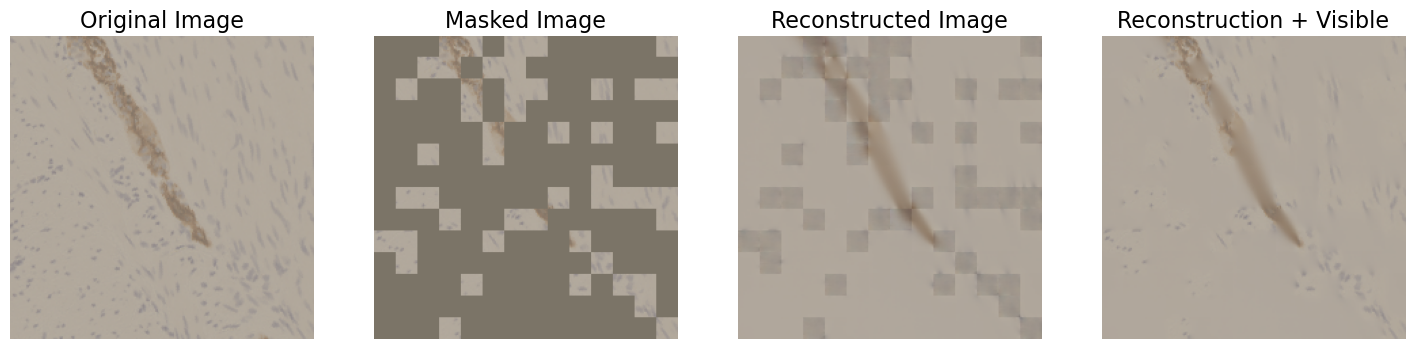

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(np.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).astype(np.uint8), cmap='gray')
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

# model = og_mae.mae_vit_base_patch16_dec512d8b(img_size=224)
# model = model.cuda()

model = og_mae.mae_vit_base_patch16_dec512d8b().cuda()
model.load_state_dict(torch.load('mae_visualize_vit_base.pth')['model'])

for batch in train_loader:
    img, ganglia_potential, ganglia_certain = batch 

    img = img.cuda().to(dtype=torch.float32) / 255  # (bsz, 3, H, W)
    ganglia_potential = ganglia_potential.cuda().long().squeeze(dim=1)  # (bsz, H, W)
    ganglia_certain = ganglia_certain.cuda().long().squeeze(dim=1)  # (bsz, H, W)
    
    with torch.cuda.amp.autocast(dtype=torch.float32):
        # Forward pass through the MAE model
        loss, pred, mask = model(img, mask_ratio=0.75)
        
        img = img.detach().cpu()
        img = torch.einsum('nchw->nhwc', img)
        
        pred = model.unpatchify(pred).detach().cpu()
        pred = torch.einsum('nchw->nhwc', pred)
        
        mask = mask.detach()
        mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
        mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
        mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
        

        # Masked image (original image with masked areas blacked out)
        img_masked = img * (1 - mask)
        
        im_paste = img * (1 - mask) + pred * mask
        
        print(img.shape)
        print(mask.shape)
        print(img_masked.shape)
        print(pred.shape)
        print(im_paste.shape)

        plt.figure(figsize=(18, 6))
        plt.subplot(1, 4, 1)
        show_image(img[0].numpy(), 'Original Image')
        plt.subplot(1, 4, 2)
        show_image(img_masked[0].numpy(), 'Masked Image')
        plt.subplot(1, 4, 3)
        show_image(pred[0].numpy(), 'Reconstructed Image')
        plt.subplot(1, 4, 4)
        show_image(im_paste[0].numpy(), 'Reconstruction + Visible')
        plt.show()

    break 


In [97]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    # Convert the tensor to a NumPy array if it's not already
    if isinstance(image, torch.Tensor):
        image = image.numpy()
    plt.imshow(np.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).astype(np.uint8))
    plt.title(title, fontsize=16)
    plt.axis('off')

model = og_mae.mae_vit_base_patch16_dec512d8b()
model.load_state_dict(torch.load('mae_visualize_vit_base.pth')['model'])

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)
    print(x[0].shape)
    print(mask[0].shape)
    print(im_masked[0].shape)
    print(y[0].shape)
    

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

torch.Size([224, 224, 3])


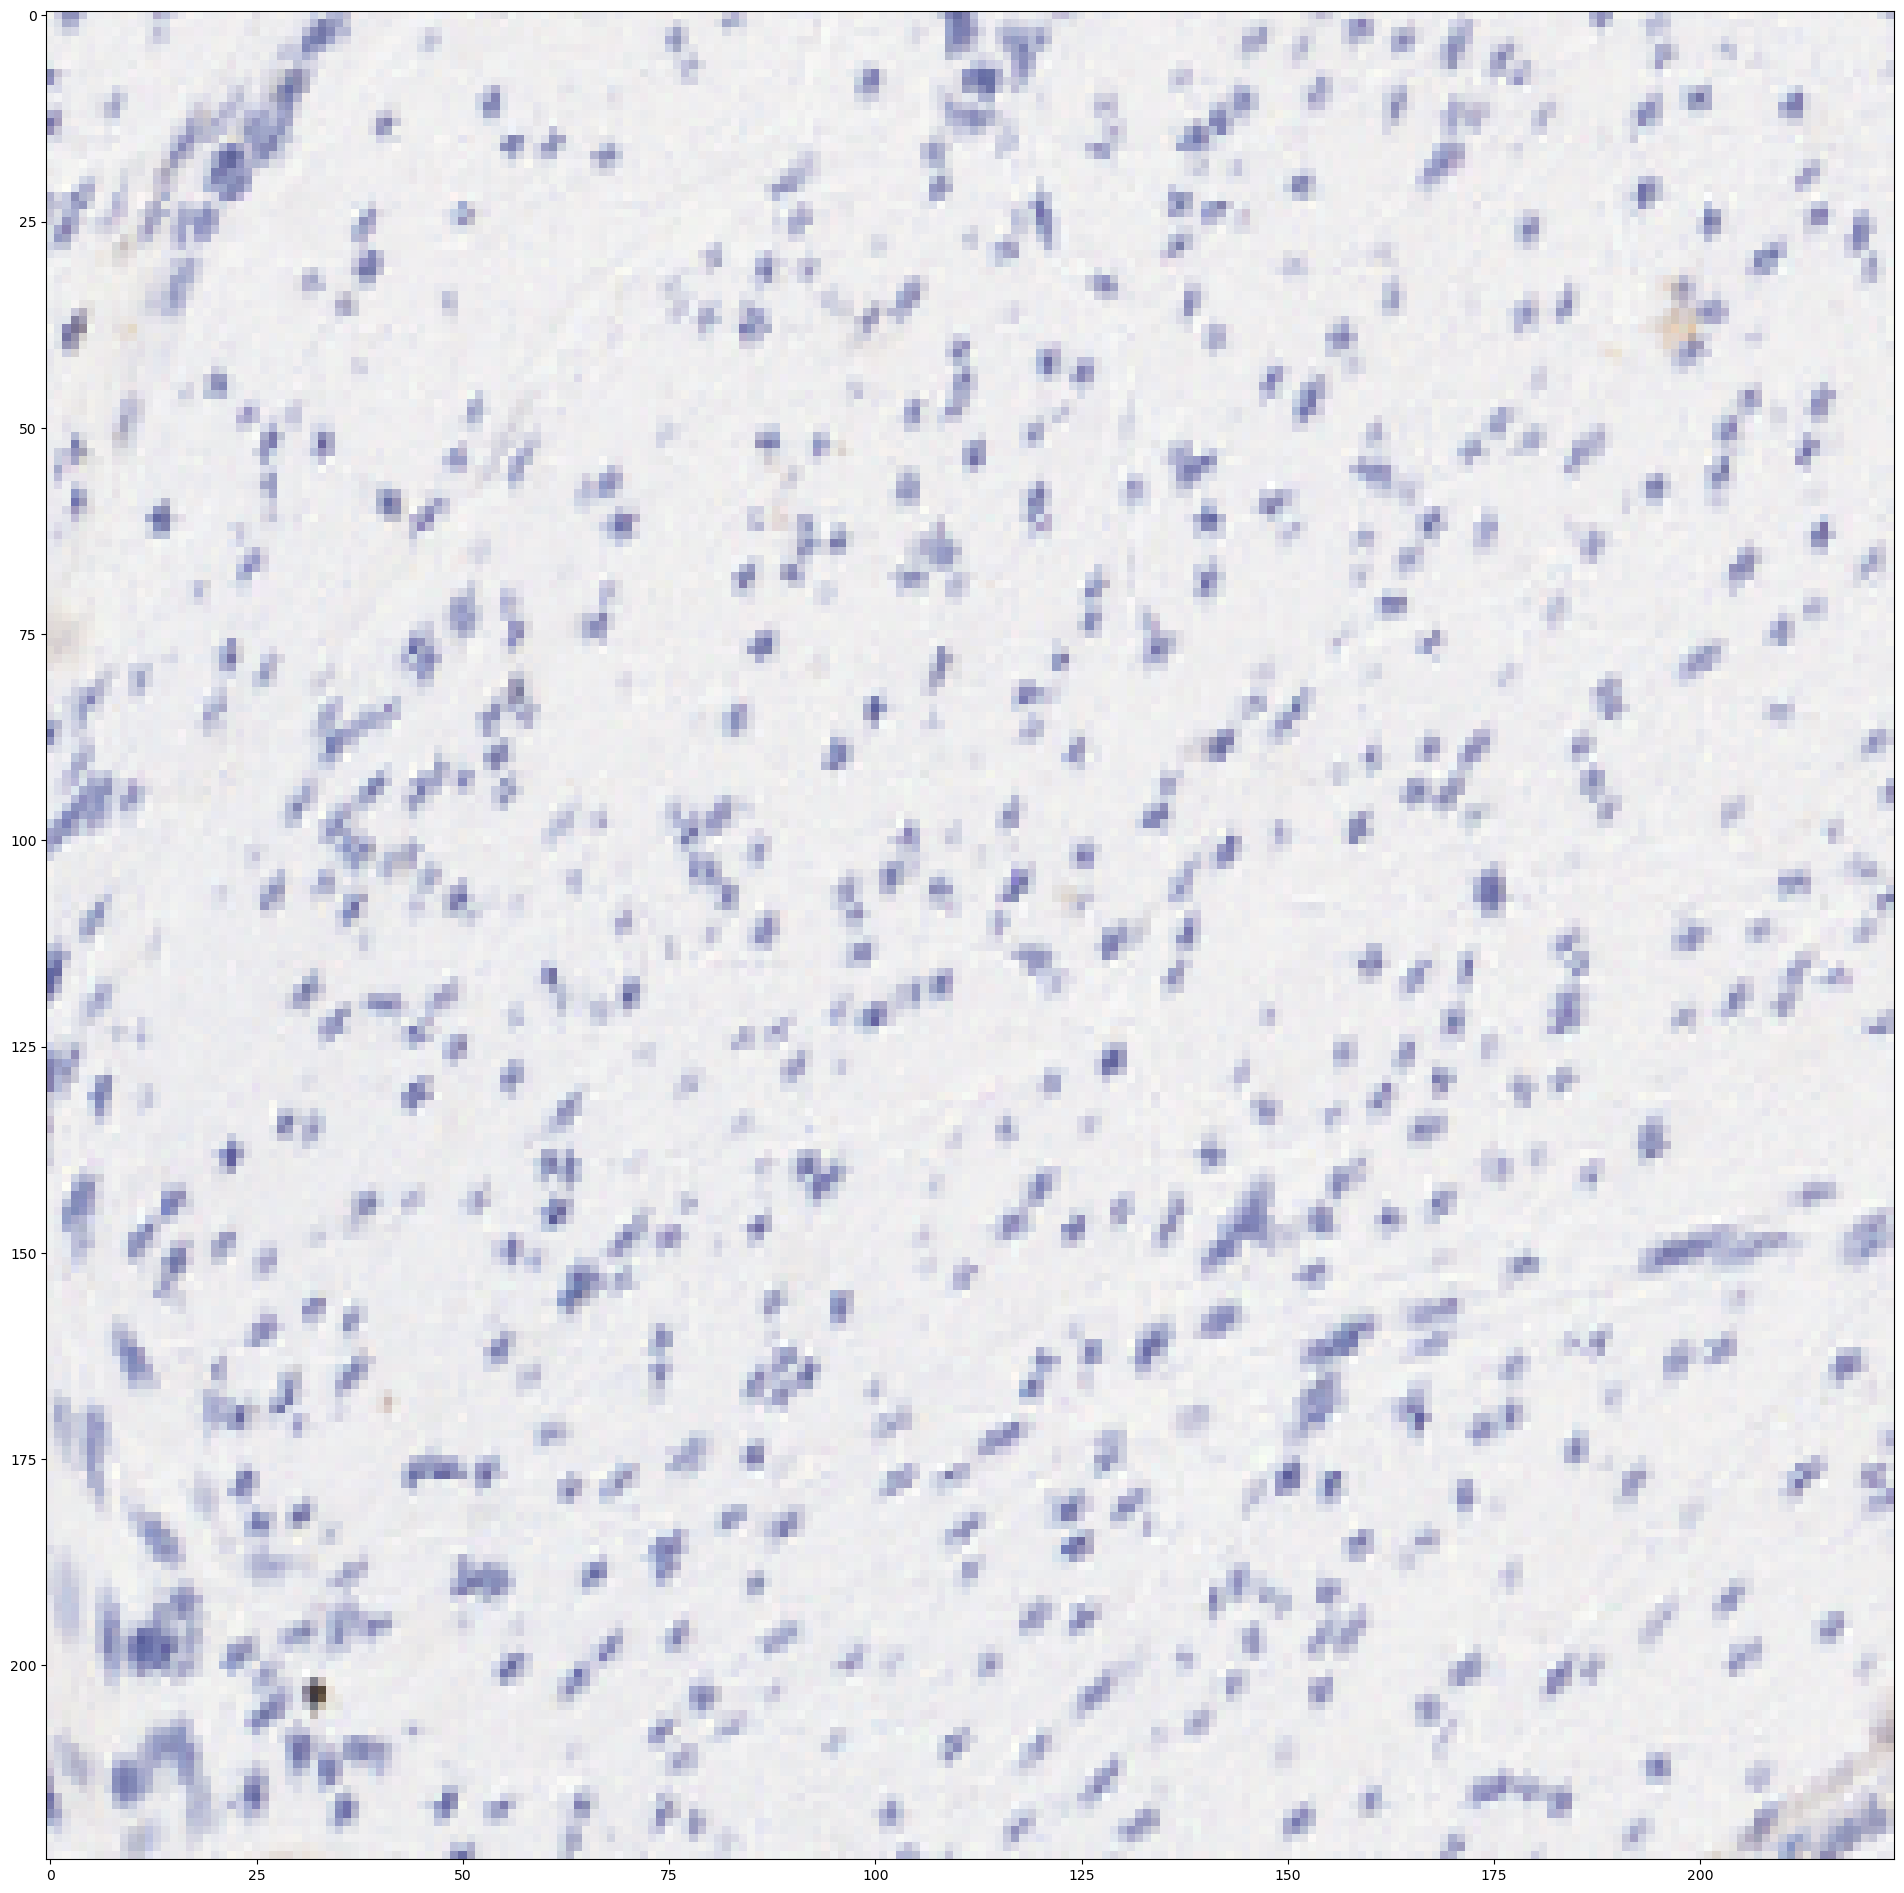

In [98]:
# load an image
for batch in train_loader:
    img, ganglia_potential, ganglia_certain = batch  # load from batch
    break

selected_img = img[0]
selected_img = torch.einsum('chw->hwc', selected_img)
print(selected_img.shape)  # Should be (3, 224, 224)

# plt.rcParams['figure.figsize'] = [5, 5]
# show_image(selected_img)

plt.imshow(selected_img, cmap='gray')
plt.show()

MAE with pixel reconstruction:
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])


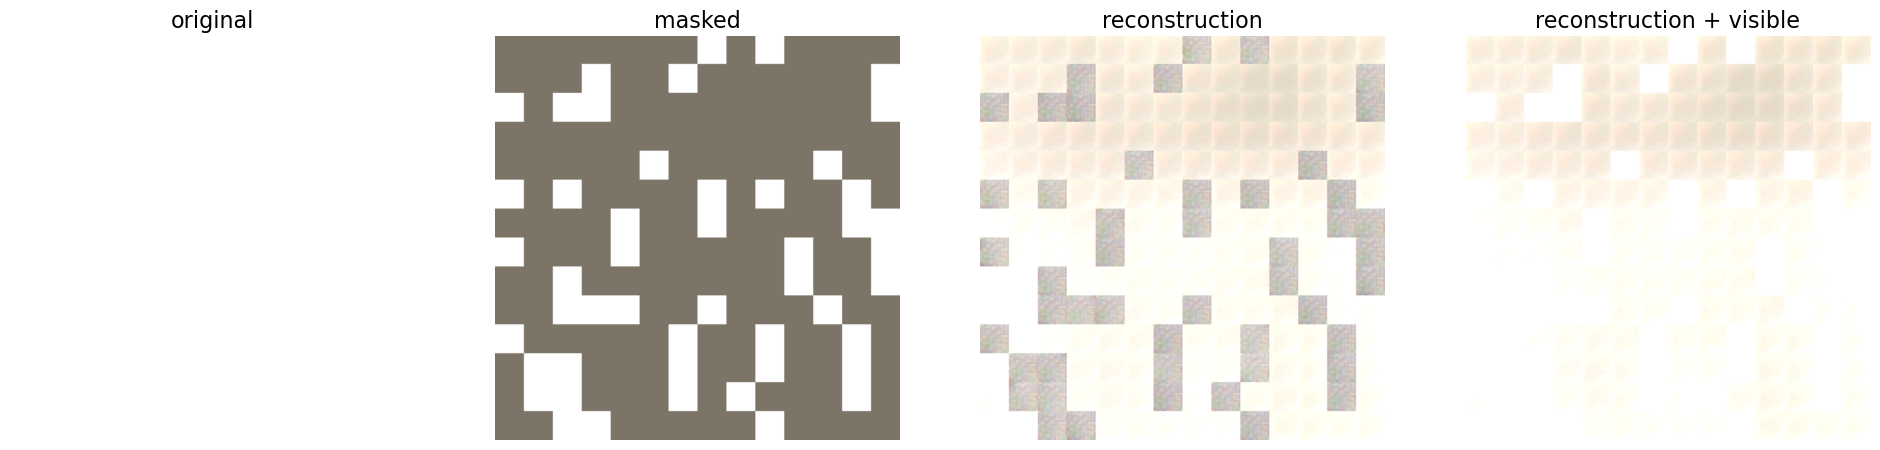

In [99]:
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(selected_img, model)

In [6]:
# learning_rates = [2e-3, 5e-3, 8e-3]
learning_rates = [1e-4, 2e-4, 5e-4, 1e-3]
best_lr = None
best_model_state = None
best_linear_layer = None
use_mixup = False
lambda_values = [0.2, 0.5, 0.8]

columns = ['Learning Rate', 'Epoch', 'Train Loss', 'Val mIoU certain', 'Test mIoU certain', 'Val mIoU combined', 'Test mIoU combined']
model_info_df = pd.DataFrame(columns=columns)

for base_lr in learning_rates:

    print(f'Learning Rate: {base_lr}')

    batch_size = 64

    train_dataset = HirschImagesDataset(data_file_path="ganglia_train", do_augmentation=True)
    train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=8
                             )

    val_dataset = HirschImagesDataset(data_file_path="ganglia_val", do_augmentation=False)
    val_loader = DataLoader(val_dataset,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=8
                           )

    test_dataset = HirschImagesDataset(data_file_path="ganglia_test", do_augmentation=False)
    test_loader = DataLoader(test_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=8
                            )

    best_val_miou = 0
    #base_lr = 1e-4
    learning_rate = base_lr * batch_size / 256 # added

    model = og_mae.mae_vit_base_patch16_dec512d8b().cuda()
    model.load_state_dict(torch.load('mae_visualize_vit_base.pth')['model'])
    linear = nn.Linear(768, 512).cuda()

    # optimizer
    backbone_params = model.parameters()
    linear_params = linear.parameters()
    # head_params = seg_head.parameters()
    opt = torch.optim.AdamW([{'params': backbone_params}, {'params': linear_params}], lr=learning_rate)
#     class_weights = torch.tensor([1.0, 2.0], dtype=torch.bfloat16).cuda()
    loss_function = torch.nn.CrossEntropyLoss()

    # Prep LR stepping
    epochs = 50
    multiplier = 1
    backbone_config = {'lr': learning_rate,
                       'warmup_epochs': 5,
                       'min_lr': 0,
                       'epochs': epochs}

    head_config = {'lr': multiplier * learning_rate,
                   'warmup_epochs': 5,
                   'min_lr': 0,
                   'epochs': epochs}
    num_down = 0
    for epoch in range(epochs):
        if num_down >= 20:
            break

        opt.param_groups[0]['lr'] = adjust_learning_rate(epoch, backbone_config)
        opt.param_groups[1]['lr'] = adjust_learning_rate(epoch, head_config)

        current_lr_backbone = opt.param_groups[0]['lr']  # confirm
        current_lr_head = opt.param_groups[1]['lr']  # confirm

        train_losses = []

        model = model.train()
        # seg_head = seg_head.train()
        linear = linear.train()
        for batch in train_loader:
            img, ganglia_potential, ganglia_certain = batch  # load from batch

            # Q: I shouldn't augment again right?

            img = img.cuda().to(dtype=torch.bfloat16) / 255  # (bsz, 3, H, W)
            ganglia_potential = ganglia_potential.cuda().long().squeeze(dim=1)  # (bsz, H, W)
            ganglia_certain = ganglia_certain.cuda().long().squeeze(dim=1)  # (bsz, H, W)
            if torch.randint(0,100,(1,)).item() > 50:
                combined_mask = (ganglia_certain + ganglia_potential).cuda().long().squeeze(dim=1)
            else:
                combined_mask = ganglia_certain
#             combined_mask = torch.clamp(combined_mask, max=1) # to make it 1 and 0 only


            # Mix the inputs and the labels here
            # 1st Step: flip the order of the images
            if use_mixup:
                img_flipped = img.flip(0)
                img = (1 - lam) * img_flipped + lam * img

            with torch.cuda.amp.autocast(dtype=torch.bfloat16):
                x = model.patch_embed(img)
                x = x + model.pos_embed[:, 1:, :]

                cls_token = model.cls_token + model.pos_embed[:, :1, :]
                cls_tokens = cls_token.expand(x.shape[0], -1, -1)
                x = torch.cat((cls_tokens, x), dim=1)

                # apply Transformer blocks
                for blk in model.blocks:
                    x = blk(x)  # (bsz, L, 768)

                x = linear(x)  # (bsz, L, 512)
                logits = rearrange(x[:, 1:, :], 'b (h w) (c i j) -> b c (h i) (w j)', h=14, w=14, c=2, i=16, j=16)  # (bsz, 2, H, W)
                # logits = seg_head(features=x[:, 1:, :], HW_input=224, HW_target=224)  # (bsz, 2, H, W)

#             print(logits.shape, combined_mask.shape)
            if use_mixup:
                loss_original = loss_function(logits, combined_mask)
                loss_flipped = loss_function(logits, combined_mask.flip(0))
                loss = (1 - lam) * loss_flipped + lam * loss_original
            else:
                loss = loss_function(logits, combined_mask)
#                 print(logits.dtype, combined_mask.dtype)


            loss.backward()
            opt.step()
            opt.zero_grad()
            train_losses.append(loss.item())

#         val_losses = []
        thresh = 0.5
        all_predictions_val  = []
        all_gt_val_combined = []
        all_gt_val_certain = []
        model.eval()
        for batch in val_loader:
            img, ganglia_potential, ganglia_certain = batch  # load from batch
            img = img.cuda().to(dtype=torch.bfloat16) / 255  # (bsz, 3, H, W)
            ganglia_potential = ganglia_potential.cuda().long().squeeze(dim=1)  # (bsz, H, W)
            ganglia_certain = ganglia_certain.cuda().long().squeeze(dim=1)  # (bsz, H, W)
            combined_mask = (ganglia_certain + ganglia_potential).cuda().long().squeeze(dim=1)

            with torch.no_grad():
                with torch.cuda.amp.autocast(dtype=torch.bfloat16):
                    x = model.patch_embed(img)
                    x = x + model.pos_embed[:, 1:, :]

                    cls_token = model.cls_token + model.pos_embed[:, :1, :]
                    cls_tokens = cls_token.expand(x.shape[0], -1, -1)
                    x = torch.cat((cls_tokens, x), dim=1)

                    # apply Transformer blocks
                    for blk in model.blocks:
                        x = blk(x)  # (bsz, L, 768)

                    x = linear(x)  # (bsz, L, 512)
                    logits = rearrange(x[:, 1:, :], 'b (h w) (c i j) -> b c (h i) (w j)', h=14, w=14, c=2, i=16,
                                       j=16)  # (bsz, 2, H, W)
                    probability = logits.softmax(dim=1)
                    predictions = (probability[:,1,:, :] > thresh).long()
#                     predictions  = logits.argmax(dim=1)  # (bza, H, W)
            all_predictions_val.append(predictions.cpu())
            all_gt_val_certain.append(ganglia_certain.cpu())
            all_gt_val_combined.append(combined_mask.cpu())
        
                    # logits = seg_head(features=x[:, 1:, :], HW_input=224, HW_target=224)  # (bsz, 2, H, W)

#             loss = loss_function(logits, plexus)
#             val_losses.append(loss.item())
        all_predictions_val = torch.cat(all_predictions_val, dim=0).numpy()
        all_gt_val_certain = torch.cat(all_gt_val_certain, dim=0).numpy()
        all_gt_val_combined = torch.cat(all_gt_val_combined, dim=0).numpy()

        val_miou_certain = compute_iou(all_predictions_val, all_gt_val_certain)
        val_miou_combined = compute_iou(all_predictions_val, all_gt_val_combined)

#         val_miou = mean_iou(results=all_predictions_val,
#                     gt_seg_maps=all_gt_val,
#                     num_classes=2,
#                     ignore_index=-1)

#         test_losses = []
        thresh = 0.5
        all_predictions_test  = []
        all_gt_test_combined = []
        all_gt_test_certain = []
        model.eval()
        for batch in test_loader:
            img, ganglia_potential, ganglia_certain = batch  # load from batch
            img = img.cuda().to(dtype=torch.bfloat16) / 255  # (bsz, 3, H, W)
            ganglia_potential = ganglia_potential.cuda().long().squeeze(dim=1)  # (bsz, H, W)
            ganglia_certain = ganglia_certain.cuda().long().squeeze(dim=1)  # (bsz, H, W)
            combined_mask = (ganglia_certain + ganglia_potential).cuda().long().squeeze(dim=1)

            with torch.no_grad():
                with torch.cuda.amp.autocast(dtype=torch.bfloat16):
                    x = model.patch_embed(img)
                    x = x + model.pos_embed[:, 1:, :]

                    cls_token = model.cls_token + model.pos_embed[:, :1, :]
                    cls_tokens = cls_token.expand(x.shape[0], -1, -1)
                    x = torch.cat((cls_tokens, x), dim=1)

                    # apply Transformer blocks
                    for blk in model.blocks:
                        x = blk(x)  # (bsz, L, 768)

                    x = linear(x)  # (bsz, L, 512)
                    logits = rearrange(x[:, 1:, :], 'b (h w) (c i j) -> b c (h i) (w j)', h=14, w=14, c=2, i=16,
                                       j=16)  # (bsz, 2, H, W)
                    probability = logits.softmax(dim=1)
                    predictions = (probability[:,1,:, :] > thresh).long()
#                     predictions  = logits.argmax(dim=1)  # (bza, H, W)
            all_predictions_test.append(predictions.cpu())
            all_gt_test_certain.append(ganglia_certain.cpu())
            all_gt_test_combined.append(combined_mask.cpu())
                    # logits = seg_head(features=x[:, 1:, :], HW_input=224, HW_target=224)  # (bsz, 2, H, W)

#             loss = loss_function(logits, plexus)
#             test_losses.append(loss.item())
        all_predictions_test = torch.cat(all_predictions_test, dim=0).numpy()
        all_gt_test_certain = torch.cat(all_gt_test_certain, dim=0).numpy()
        all_gt_test_combined = torch.cat(all_gt_test_combined, dim=0).numpy()

        test_miou_certain = compute_iou(all_predictions_test, all_gt_test_certain)
        test_miou_combined = compute_iou(all_predictions_test, all_gt_test_combined)

#         test_miou = mean_iou(results=all_predictions_test,
#                     gt_seg_maps=all_gt_test,
#                     num_classes=2,
#                     ignore_index=-1)

        train_losses = torch.Tensor(train_losses).mean().item()
#         val_losses = torch.Tensor(val_losses).mean().item()
#         test_losses = torch.Tensor(test_losses).mean().item()
        print(f'Epoch: {epoch}, Train Loss: {train_losses}, Val mIoU certain: {val_miou_certain}, Test mIoU certain: {test_miou_certain}, Val mIoU combined: {val_miou_combined}, Test mIoU combined: {test_miou_combined}, Base LR: {base_lr}, LR Backbone: {current_lr_backbone}, LR Head: {current_lr_head},')

#         avg_val_miou = val_miou['IoU'].mean()

        if val_miou_combined > best_val_miou: # maybe add or val_miou_certain statement?
            best_val_miou = val_miou_combined
            best_lr = base_lr
#             best_model_state = copy.deepcopy(model.state_dict()) 
#             best_linear_layer = copy.deepcopy(linear.state_dict()) 
            print(f'Best Learning Rate: {best_lr}')
            print(f'SAVING')
            torch.save(obj={'backbone': model.state_dict(),
                            'linear': linear.state_dict()},
                       f=f'actual_ganglia_saved_models/ViT_IN1k_ganglia_{base_lr}_2.pt')
            
            d = {'Learning Rate': base_lr, 'Epoch': epoch, 'Train Loss': train_losses, 'Val mIoU certain': val_miou_certain, 
                 'Test mIoU certain': test_miou_certain, 'Val mIoU combined': val_miou_combined, 'Test mIoU combined': test_miou_combined}
            model_info_df = pd.concat([model_info_df, pd.DataFrame([d])], ignore_index=True)
            
            num_down = 0
        else:
            num_down += 1

        # write to logs
        with open(f'ViT_IN1k_ganglia_logs_{base_lr}_2.csv', 'a', errors="ignore") as out_file:
            csv_writer = csv.writer(out_file, delimiter=',', lineterminator='\n')
            csv_writer.writerow([epoch, train_losses, val_miou_certain, test_miou_certain, val_miou_combined, test_miou_combined, best_val_miou, current_lr_backbone, current_lr_head, base_lr])


Learning Rate: 0.0001
Epoch: 0, Train Loss: 1.3359999656677246, Val mIoU certain: 0.2337181329955604, Test mIoU certain: 0.23429113973852267, Val mIoU combined: 0.23375182839402253, Test mIoU combined: 0.23430333959235441, Base LR: 0.0001, LR Backbone: 0.0, LR Head: 0.0,
Best Learning Rate: 0.0001
SAVING
Epoch: 1, Train Loss: 0.12485083192586899, Val mIoU certain: 0.49979977230123573, Test mIoU certain: 0.4998603221774573, Val mIoU combined: 0.49975602907058897, Test mIoU combined: 0.49984515409045976, Base LR: 0.0001, LR Backbone: 5e-06, LR Head: 5e-06,
Best Learning Rate: 0.0001
SAVING
Epoch: 2, Train Loss: 0.004009185824543238, Val mIoU certain: 0.4997997737247988, Test mIoU certain: 0.4998603221774573, Val mIoU combined: 0.4997560304941512, Test mIoU combined: 0.49984515409045976, Base LR: 0.0001, LR Backbone: 1e-05, LR Head: 1e-05,
Best Learning Rate: 0.0001
SAVING
Epoch: 3, Train Loss: 0.003035186789929867, Val mIoU certain: 0.4997997737247988, Test mIoU certain: 0.49986032217745

In [7]:
max_miou_per_lr = model_info_df.groupby('Learning Rate')['Val mIoU combined'].transform('max')
max_rows = model_info_df[model_info_df['Val mIoU combined'] == max_miou_per_lr]
max_rows.to_csv("actual_ganglia_saved_models/ViT_IN1k_ganglia_logs_v3.csv")

In [8]:
model_info_df.to_csv("actual_ganglia_saved_models/ViT_IN1k_ganglia_all_v3.csv")

In [29]:
best = get_model_info_df.iloc[get_model_info_df['Val mIoU'].idxmax()]
best.to_csv("delete.csv")